In [119]:
#Loading Libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns;
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from scipy.optimize import minimize
import random
import matplotlib.pyplot as plt

In [2]:
#Linear Regression Functions
def CostFunction(X,y,theta):
    m=len(y)
    costfunc=0
    costfunc= (1/(2*m))*np.sum(np.power((np.dot(X,theta)-y),2))
    return costfunc

def BGD(X,y,theta,alpha,num_iters,tol=1e-3):
    m=len(y)
    costs=[]
    for i in range(num_iters):
        theta = theta - (alpha/m) * X.T.dot(np.dot(X,theta)-y)
        costfunc = CostFunction(X,y,theta)
        costs.append(costfunc)
        if i>1 and (costs[i-1]-costs[i]) < tol:
            print('Algorithm Coverged')
            iters = i
            break
    return costs,theta,iters

def GDN(X,y,theta,alpha,num_iters):
    m=len(y)
    costs=[]
    costfunc = CostFunction(X,y,theta)
    costs.append(costfunc)
    for i in range(num_iters):
        theta = theta - (alpha/m) * X.T.dot(np.dot(X,theta)-y)
        costfunc = CostFunction(X,y,theta)
        costs.append(costfunc)
    return costs,theta

def Normalize(X):
    X_norm = X
    mean    = np.zeros((1, X.shape[1]))
    stdev = np.zeros((1, X.shape[1]))
    for i in range(X.shape[1]):
        mean[:,i] = np.mean(X[:,i])
        stdev[:,i] = np.std(X[:,i])
        X_norm[:,i] = (X[:,i] - float(mean[:,i]))/float(stdev[:,i])
    return X_norm, mean, stdev

def Eqn(x,y):
    xx = np.dot(x.T,x)
    xy = np.dot(x.T,y)
    xxi = np.linalg.inv(xx)
    b = np.dot(xxi,xy)
    return b

def plotcost(costs,text):
    plt.plot(costs,label=text)
    plt.ylabel('Cost')
    plt.xlabel('Iterations')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

def Test_Train_Split(X,y,tst_sze):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tst_sze,random_state=0)
    y_train=y_train.reshape(-1,1)   
    y_test=y_test.reshape(-1,1)
    m=X_train.shape[0]
    return X_train,X_test,y_train,y_test,m

def predict(X_test,mean,stdev,theta):
    Xtest_normal = (X_test - mean)/stdev
    m=X_test.shape[0]
    ones=np.ones((m,1))
    Xtest_normal= np.hstack((ones,Xtest_normal))
    y_hat = np.dot(Xtest_normal,theta)
    return y_hat,m

def RMSE(y,y_hat,m2):
    RMSE = np.sqrt(np.sum(np.power((y-y_hat),2))/m2)
    return RMSE

In [3]:
#Logistic Regression Function
def logcostfunction(X, y,theta):
    m = len(y)
    h = sigmoid(np.dot(X,theta))    
    a = np.multiply(y , np.log(h))
    b = np.multiply((1 - y) , np.log(1 - h))
    J = -1 *(1./m ) * ((a+b).sum())
    return J

def LogBGD(theta, X, y,alpha,num_iters,tol=1e-5):
    m = len(y)
    costs=[]
    for i in range(num_iters):
        grad = 0
        h = sigmoid(np.dot(X,theta))
        grad = (1. / m) * np.dot(X.T,(h - y))
        theta=theta-alpha*grad
        cost = logcostfunction(X,y,theta)
        costs.append(cost)
        if i>1 and (costs[i-1]-costs[i]) < tol:
            print('Algorithm Coverged')
            iters = i
            break
    return costs,theta,iters

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logpredict(theta, X, logmean, logstdev, threshold=0.5):
    lognormX= (X - logmean)/logstdev
    m=X_norm.shape[0]
    ones=np.ones((m,1))
    newX=np.hstack((ones,X_norm))
    p = sigmoid(newX.dot(theta)) >= threshold
    return(p.astype('int'))

def Accuracy(y,y_hat):
    m = len(y)
    corrects = 0
    for i in range(0, m):
        if y[i] == y_hat[i]:
            corrects += 1
    return (100 * corrects) / m

In [79]:
sgemm = pd.read_csv("C:/Users/priya/OneDrive/Namrata UTD/Sem2/AppliedMachineLearning-Farooq-BUAN6341/Assignment1/Dataset/sgemm_product.csv")
#First few rows of the data set
sgemm.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


In [80]:
sgemm["Run"]=(sgemm["Run1 (ms)"] + sgemm["Run2 (ms)"] + sgemm["Run3 (ms)"] + sgemm["Run4 (ms)"])/4

In [81]:
sgemm.drop(["Run1 (ms)","Run2 (ms)","Run3 (ms)","Run4 (ms)"],axis=1,inplace=True)
sgemm

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,116.3700
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.7050
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,80.5650
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,86.6375
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,118.6625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241595,128,128,32,32,32,32,32,8,4,4,1,0,1,1,17.8175
241596,128,128,32,32,32,32,32,8,4,4,1,1,0,0,36.0350
241597,128,128,32,32,32,32,32,8,4,4,1,1,0,1,35.1600
241598,128,128,32,32,32,32,32,8,4,4,1,1,1,0,28.4525


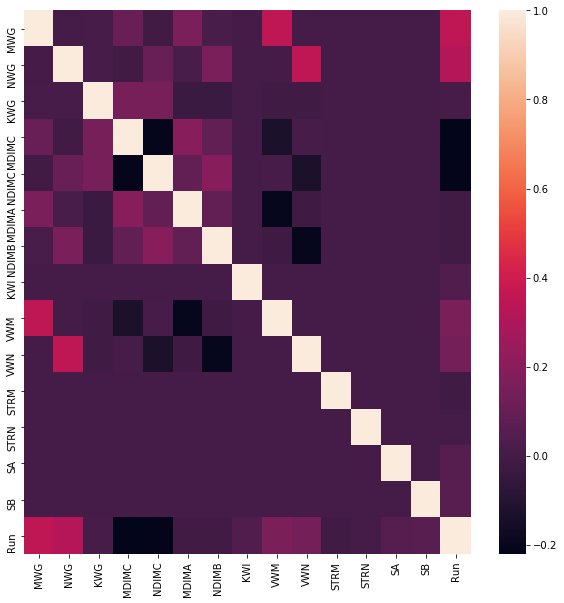

In [7]:
corrMatrix = sgemm.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrMatrix)

In [8]:
y = sgemm['Run'].values
X = sgemm[['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM', 'VWN', 'STRM', 'STRN', 'SA','SB']].values

In [9]:
#Splitting Test Train Split
X_train,X_test,y_train,y_test,m = Test_Train_Split(X,y,tst_sze=0.2)
#Normalizing Features
X_norm, mean, stdev = Normalize(X_train)
#Horizontal Stacking of intercept to the feature Matrix
ones=np.ones((m,1))
newX=np.hstack((ones,X_norm))
#Initializing theta values to Zeros
var= X_train.shape[1] + 1

In [10]:
#Logistic Regression
logy = sgemm['Run'].values
logX = sgemm[['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM', 'VWN', 'STRM', 'STRN', 'SA','SB']].values      

#Converting to Binary Classification Problem
logy=(sgemm['Run']>int(logy.mean())).astype(int).values
logy.mean()
#Splitting Test Train Split
logX_train,logX_test,logy_train,logy_test,logm = Test_Train_Split(logX,logy,tst_sze=0.2)

logvar= logX_train.shape[1] + 1
logtheta=np.zeros((logvar,1))
lognormX, logmean, logstdev = Normalize(logX_train)

#Horizontal Stacking of intercept to the feature Matrix
logones=np.ones((logm,1))
lognewX=np.hstack((logones,lognormX))

In [11]:
#Experiment 1
#Linear Regression
learning_rates = [0.5,0.1,0.05,0.01, 0.005, 0.001]
num_iters=100000
RMSE_trains=[]
RMSE_tests=[]
iters_s=[]
costs_s=[]
for i in range(len(learning_rates)):
    theta=np.zeros((var,1))
    costs,theta,iters = BGD(newX,y_train,theta,learning_rates[i],num_iters)
    y_hat_train = np.dot(newX,theta)
    RMSE_train=RMSE(y_train,y_hat_train,m)
    y_hat_test,m2 = predict(X_test,mean,stdev,theta)
    RMSE_test=RMSE(y_test,y_hat_test,m2)
    RMSE_trains.append(RMSE_train)
    RMSE_tests.append(RMSE_test)
    iters_s.append(iters)
    costs_s.append(costs[-1])

Algorithm Coverged
Algorithm Coverged
Algorithm Coverged
Algorithm Coverged
Algorithm Coverged
Algorithm Coverged


In [12]:
Experiment1 = pd.DataFrame(
        {'Learning Rate'    : learning_rates,
         'CostFunctionValue': costs_s,
         'Iterations'       : iters_s,
         'Train Error'      : RMSE_trains,
         'Test Error'       : RMSE_tests
                })
Experiment1

,Learning Rate,CostFunctionValue,Iterations,Train Error,Test Error
0,0.500,47632.077962,139,308.648920,291.634506
1,0.100,47632.125122,612,308.649073,291.614755
2,0.050,47632.183790,1145,308.649263,291.601176
3,0.010,47632.657067,4780,308.650796,291.552679
4,0.005,47633.249068,8741,308.652714,291.525884
5,0.001,47637.978703,34196,308.668038,291.501882


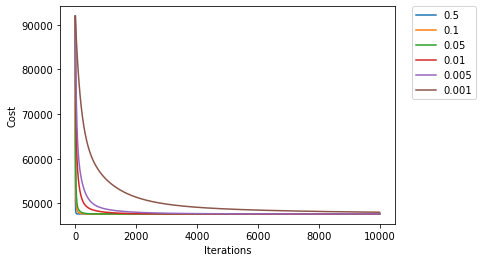

In [13]:
learning_rates = [0.5,0.1,0.05,0.01, 0.005, 0.001]
num_iters=10000
for i in range(len(learning_rates)):
    theta=np.zeros((var,1))
    costs,theta= GDN(newX,y_train,theta,learning_rates[i],num_iters)
    plotcost(costs,text=learning_rates[i])

In [14]:
theta

array([[ 158.81360058],
       [ 158.69794298],
       [ 144.8530047 ],
       [  18.88874381],
       [-101.74735742],
       [ -97.80042511],
       [   8.65381026],
       [   7.81621623],
       [  40.91231157],
       [  32.23273423],
       [  24.82665413],
       [ -26.25502031],
       [  18.57200701],
       [  53.83172244],
       [  25.95865034]])

In [15]:
#Logistic Regression
learning_rates = [0.5,0.1,0.05,0.01, 0.005, 0.001]
num_iters=100000
accuracytrain=[]
accuracytest=[]
iters_s=[]
costs_s=[]
for i in range(len(learning_rates)):
    theta_lo=np.zeros((logvar,1))
    costs,theta,iters = LogBGD(theta_lo, lognewX, logy_train,learning_rates[i],num_iters)
    logy_hat_train = logpredict(theta, logX_train,logmean,logstdev)
    accuracy_train=Accuracy(logy_train,logy_hat_train)
    logy_hat_test = logpredict(theta, logX_test,logmean,logstdev)
    accuracy_test=Accuracy(logy_test,logy_hat_test)
    accuracytrain.append(accuracy_train)
    accuracytest.append(accuracy_test)
    iters_s.append(iters)
    costs_s.append(costs[-1])

Algorithm Coverged
Algorithm Coverged
Algorithm Coverged
Algorithm Coverged
Algorithm Coverged
Algorithm Coverged


In [16]:
logExperiment1= pd.DataFrame(
                {'Learning Rate': learning_rates,
                 'Cost'         : costs_s,
                 'Iterations'   : iters_s,
                 'Train Accuracy'   : accuracytrain,
                 'Test Accuracy'    : accuracytest
                        })
logExperiment1

,Learning Rate,Cost,Iterations,Train Accuracy,Test Accuracy
0,0.500,0.287313,351,87.564673,62.858030
1,0.100,0.290790,1037,87.645902,63.073262
2,0.050,0.294352,1577,87.627794,63.110513
3,0.010,0.314062,3649,87.127483,63.787252
4,0.005,0.330946,4918,86.627173,64.478477
5,0.001,0.404512,8168,83.135348,68.185017


In [17]:
theta

array([[-0.49108857],
       [ 0.73393894],
       [ 0.6251874 ],
       [ 0.06238925],
       [-0.41907486],
       [-0.39203625],
       [-0.10071324],
       [-0.09976631],
       [-0.27631621],
       [ 0.10015544],
       [ 0.07613571],
       [ 0.16592636],
       [-0.18788405],
       [-0.3570021 ],
       [ 0.04593363]])

Algorithm Coverged
Algorithm Coverged
Algorithm Coverged
Algorithm Coverged
Algorithm Coverged
Algorithm Coverged


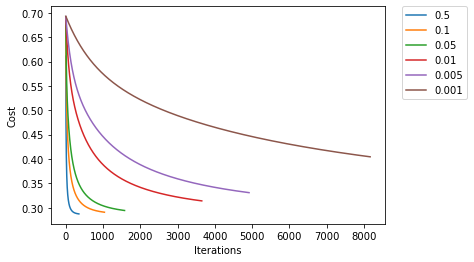

In [22]:
learning_rates = [0.5,0.1,0.05,0.01, 0.005, 0.001]
num_iters=10000
for i in range(len(learning_rates)):
    theta_lo=np.zeros((logvar,1))
    costs,theta,iters = LogBGD(theta_lo, lognewX, logy_train,learning_rates[i],num_iters)
    plotcost(costs,text=learning_rates[i])

In [24]:
#Experiment 2
#Linear Regression - Thresholding
learning_rates = [0.1,0.05,0.01]
convergences=[1e-1,1e-2,1e-3,1e-4]
num_iters=100000
RMSE_trains_exp2=[]
RMSE_tests_exp2=[]
iters_s_exp2=[]
costs_s_exp2=[]
tol_s=[]
learning_rates_s=[]
for j in range(len(learning_rates)):
    for i in range(len(convergences)):
        theta=np.zeros((var,1))
        costs,theta,iters = BGD(newX,y_train,theta,learning_rates[j],num_iters,tol=convergences[i])
        y_hat_train = np.dot(newX,theta)
        RMSE_train_exp2=RMSE(y_train,y_hat_train,m)
        y_hat_test,m2 = predict(X_test,mean,stdev,theta)
        RMSE_test_exp2=RMSE(y_test,y_hat_test,m2)
        RMSE_trains_exp2.append(RMSE_train_exp2)
        RMSE_tests_exp2.append(RMSE_test_exp2)
        iters_s_exp2.append(iters)
        costs_s_exp2.append(costs[-1])
        learning_rates_s.append(learning_rates[j])
        tol_s.append(convergences[i])

Algorithm Coverged
Algorithm Coverged
Algorithm Coverged
Algorithm Coverged
Algorithm Coverged
Algorithm Coverged
Algorithm Coverged
Algorithm Coverged
Algorithm Coverged
Algorithm Coverged
Algorithm Coverged
Algorithm Coverged


In [26]:
Experiment2 = pd.DataFrame(
                {'Learning Rate'         : learning_rates_s,
                 'Convergence Threshold' : tol_s,
                 'Cost'                  : costs_s_exp2,
                 'Iterations'            : iters_s_exp2,
                 'Train RMSE'            : RMSE_trains_exp2,
                 'Test RMSE'             : RMSE_tests_exp2
                        })
Experiment2

,Learning Rate,Convergence Threshold,Cost,Iterations,Train RMSE,Test RMSE
0,0.10,0.1000,47637.833488,341,308.667567,291.500885
1,0.10,0.0100,47632.649880,476,308.650773,291.553133
2,0.10,0.0010,47632.125122,612,308.649073,291.614755
3,0.10,0.0001,47632.072967,748,308.648904,291.638701
4,0.05,0.1000,47643.765387,601,308.686784,291.575562
5,0.05,0.0100,47633.234498,873,308.652667,291.526366
6,0.05,0.0010,47632.183790,1145,308.649263,291.601176
7,0.05,0.0001,47632.078954,1416,308.648923,291.633807
8,0.01,0.1000,47690.701462,2064,308.838798,292.750927
9,0.01,0.0100,47637.962697,3419,308.667986,291.501769


In [27]:
theta

array([[ 232.57009406],
       [ 161.17589049],
       [ 147.32825992],
       [  46.02487367],
       [-113.5230979 ],
       [-109.5316802 ],
       [   0.38738354],
       [  -0.96425031],
       [  25.31103272],
       [  21.27639593],
       [  13.52309258],
       [  -9.33914525],
       [   0.88439379],
       [  39.30614229],
       [  47.54590839]])

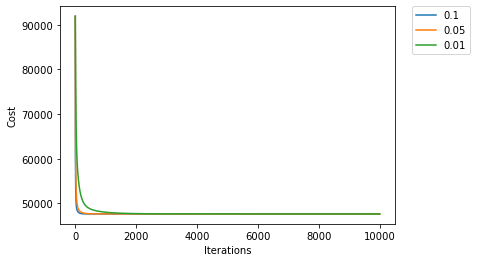

In [34]:
learning_rates = [0.1,0.05,0.01]
num_iters=10000
for i in range(len(learning_rates)):
    theta=np.zeros((var,1))
    costs,theta= GDN(newX,y_train,theta,learning_rates[i],num_iters)
    plotcost(costs,text=learning_rates[i])

In [56]:
#Experiment 3
#8 Randomly selected Features
y8=sgemm['Run'].values
X8=sgemm[['KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM', 'VWN']].values

#Splitting Test Train Split
X_train8,X_test8,y_train8,y_test8,m8 = Test_Train_Split(X8,y8,tst_sze=0.2)
#Normalizing Features
X_norm8, mean8, stdev8 = Normalize(X_train8)
#Horizontal Stacking of intercept to the feature Matrix
ones8=np.ones((m8,1))
newX8=np.hstack((ones8,X_norm8))
#Initializing theta values to Zeros
var8= X_train8.shape[1] +1

In [57]:
learning_rates8 = [0.1,0.05,0.01]
num_iters8=100000
RMSE_trains8=[]
RMSE_tests8=[]
iters_s8=[]
costs_s8=[]
for i in range(len(learning_rates8)):
    theta8=np.zeros((var8,1))
    costs8,theta8,iters8 = BGD(newX8,y_train8,theta8,learning_rates8[i],num_iters8)
    y_hat_train8 = np.dot(newX8,theta8)
    RMSE_train8=RMSE(y_train8,y_hat_train8,m8)
    y_hat_test8,m28 = predict(X_test8,mean8,stdev8,theta8)
    RMSE_test8=RMSE(y_test8,y_hat_test8,m28)
    RMSE_trains8.append(RMSE_train8)
    RMSE_tests8.append(RMSE_test8)
    iters_s8.append(iters8)
    costs_s8.append(costs8[-1])

Algorithm Coverged
Algorithm Coverged
Algorithm Coverged


In [58]:
Experiment3 =pd.DataFrame(
        {'Learning Rate': learning_rates8,
         'Cost'         : costs_s8,
         'Iterations'   : iters_s8,
         'Train RMSE'   : RMSE_trains8,
         'Test RMSE'    : RMSE_tests8
                })
Experiment3

,Learning Rate,Cost,Iterations,Train RMSE,Test RMSE
0,0.10,62521.653266,392,353.614630,336.798703
1,0.05,62521.690349,735,353.614735,336.807979
2,0.01,62521.984483,3090,353.615567,336.844518


In [59]:
theta8

array([[221.33484205],
       [ 46.82774657],
       [-95.53662804],
       [-93.43528918],
       [ 51.88837849],
       [ 46.77412093],
       [ 26.11324278],
       [ 88.39906652],
       [ 74.38734417]])

In [64]:
#Logistic Regression
logy8 = sgemm['Run'].values
logX8 = sgemm[['KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM', 'VWN']].values      

#Converting to Binary Classification Problem
logy8=(sgemm['Run']>int(logy8.mean())).astype(int).values
logy8.mean()

#Splitting Test Train Split
logX_train,logX_test,logy_train,logy_test,logm = Test_Train_Split(logX,logy,tst_sze=0.2)

logvar= logX_train.shape[1] + 1
logtheta=np.zeros((logvar,1))
lognormX, logmean, logstdev = Normalize(logX_train)

#Horizontal Stacking of intercept to the feature Matrix
logones=np.ones((logm,1))
lognewX=np.hstack((logones,lognormX))

In [140]:
learning_rates8 = [0.5,0.1,0.01]
num_iters8=100000
accuracytrain8=[]
accuracytest8=[]
iters_s8=[]
costs_s8=[]
for i in range(len(learning_rates8)):
    theta_lo=np.zeros((logvar,1))
    costs,theta,iters = LogBGD(theta_lo, lognewX, logy_train,learning_rates8[i],num_iters8)
    logy_hat_train = logpredict(theta, logX_train,logmean,logstdev)
    accuracy_train=Accuracy(logy_train,logy_hat_train)
    logy_hat_test = logpredict(theta, logX_test,logmean,logstdev)
    accuracy_test=Accuracy(logy_test,logy_hat_test)
    accuracytrain8.append(accuracy_train)
    accuracytest8.append(accuracy_test)
    iters_s8.append(iters)
    costs_s8.append(costs[-1])

Algorithm Coverged
Algorithm Coverged
Algorithm Coverged


In [66]:
logExperiment3= pd.DataFrame(
                {'Learning Rate': learning_rates8,
                 'Cost'         : costs_s8,
                 'Iterations'   : iters_s8,
                 'Train Accuracy'   : accuracytrain8,
                 'Test Accuracy'    : accuracytest8
                        })
logExperiment3

,Learning Rate,Cost,Iterations,Train Accuracy,Test Accuracy
0,0.50,0.287313,351,87.564673,62.858030
1,0.10,0.290790,1037,87.645902,63.073262
2,0.01,0.314062,3649,87.127483,63.787252


In [124]:
#Experiment 4
reg = LassoCV()
reg.fit(X_train4, y_train4)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_train4,y_train4))
coef = pd.Series(reg.coef_, index = X_train4.columns)

Best alpha using built-in LassoCV: 5.513761
Best score using built-in LassoCV: 0.405313


Text(0.5, 1.0, 'Feature importance using Lasso Model')

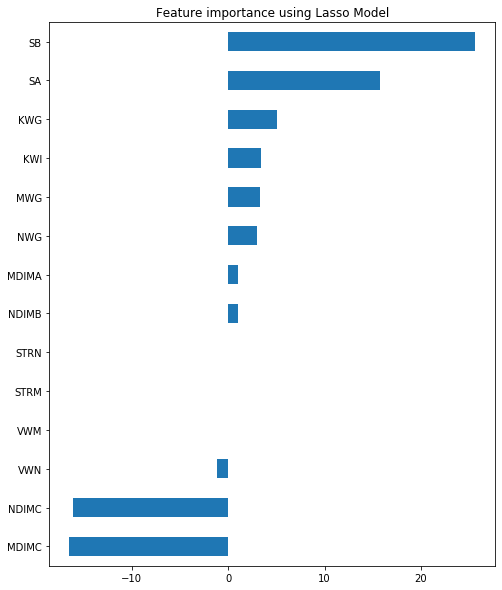

In [125]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [128]:
top8_Features = ['SB', 'SA', 'KWG','KWI', 'MWG', 'NWG', 'MDIMA', 'NDIMB' ]

In [129]:
#Selecting Top 8 Features from the Dataset
y_top4=sgemm['Run'].values
X_top4=sgemm[top8_Features].values

#Test Train Split
X_train_top4,X_test_top4,y_train_top4,y_test_top4,m_top4 = Test_Train_Split(X_top4,y_top4,tst_sze=0.2)

#Normalizing Features
X_norm_top4, meantop4, stdevtop4 = Normalize(X_train_top4)

#Horizontal Stacking of intercept to the feature Matrix
ones_top4=np.ones((m_top4,1))
newX_top4=np.hstack((ones_top4,X_norm_top4))

#Initializing theta values to Zeros
var_top4= X_train_top4.shape[1] + 1
theta_top4=np.zeros((var_top4,1))

In [130]:
sgemm[top8_Features].head()

,SB,SA,KWG,KWI,MWG,NWG,MDIMA,NDIMB
0,0,0,16,2,16,16,8,8
1,1,0,16,2,16,16,8,8
2,0,1,16,2,16,16,8,8
3,1,1,16,2,16,16,8,8
4,0,0,16,2,16,16,8,8


In [132]:
learning_rates_top4 = [0.1,0.05,0.01]
num_iters_top4=100000
RMSE_trains_top4=[]
RMSE_tests_top4=[]
iters_s_top4=[]
costs_s_top4=[]
for i in range(len(learning_rates_top4)):
    theta_top4=np.zeros((var_top4,1))
    costs_top4,theta_top4,iters_top4 = BGD(newX_top4,y_train_top4,theta_top4,learning_rates_top4[i],num_iters_top4)
    y_hat_train_top4 = np.dot(newX_top4,theta_top4)
    RMSE_train_top4=RMSE(y_train_top4,y_hat_train_top4,m_top4)
    y_hat_test_top4,m2_top4 = predict(X_test_top4,meantop4,stdevtop4,theta_top4)
    RMSE_test_top4=RMSE(y_test_top4,y_hat_test_top4,m2_top4)
    RMSE_trains_top4.append(RMSE_train_top4)
    RMSE_tests_top4.append(RMSE_test_top4)
    iters_s_top4.append(iters_top4)
    costs_s_top4.append(costs_top4[-1])

Algorithm Coverged
Algorithm Coverged
Algorithm Coverged


In [134]:
Experiment4=pd.DataFrame(
        {'Learning Rate': learning_rates_top4,
         'Cost'         : costs_s_top4,
         'Iterations'   : iters_s_top4,
         'Train RMSE'   : RMSE_trains_top4,
         'Test RMSE'    : RMSE_tests_top4
                })
Experiment4

,Learning Rate,Cost,Iterations,Train RMSE,Test RMSE
0,0.10,52360.737005,461,323.606975,326.478715
1,0.05,52360.782280,862,323.607115,326.497152
2,0.01,52361.140875,3599,323.608223,326.577064


In [135]:
theta_top4

array([[187.55839449],
       [ 46.69099061],
       [ 40.27668143],
       [  2.24778451],
       [ 25.92012843],
       [159.7249287 ],
       [144.74975425],
       [-40.39938751],
       [-38.93044606]])

In [137]:
#Logistic Regression
logy4 = sgemm['Run'].values
logX4 = sgemm[top8_Features].values      

#Converting to Binary Classification Problem
logy4=(sgemm['Run']>int(logy4.mean())).astype(int).values
logy4.mean()

#Splitting Test Train Split
logX_train,logX_test,logy_train,logy_test,logm = Test_Train_Split(logX,logy,tst_sze=0.2)

logvar= logX_train.shape[1] + 1
logtheta=np.zeros((logvar,1))
lognormX, logmean, logstdev = Normalize(logX_train)

#Horizontal Stacking of intercept to the feature Matrix
logones=np.ones((logm,1))
lognewX=np.hstack((logones,lognormX))

In [141]:
learning_rates4 = [0.5,0.1,0.01]
num_iters4=100000
accuracytrain4=[]
accuracytest4=[]
iters_s4=[]
costs_s4=[]
for i in range(len(learning_rates4)):
    theta_lo=np.zeros((logvar,1))
    costs,theta,iters = LogBGD(theta_lo, lognewX, logy_train,learning_rates4[i],num_iters4)
    logy_hat_train = logpredict(theta, logX_train,logmean,logstdev)
    accuracy_train=Accuracy(logy_train,logy_hat_train)
    logy_hat_test = logpredict(theta, logX_test,logmean,logstdev)
    accuracy_test=Accuracy(logy_test,logy_hat_test)
    accuracytrain4.append(accuracy_train)
    accuracytest4.append(accuracy_test)
    iters_s4.append(iters)
    costs_s4.append(costs[-1])

Algorithm Coverged
Algorithm Coverged
Algorithm Coverged


In [142]:
logExperiment4= pd.DataFrame(
                {'Learning Rate': learning_rates4,
                 'Cost'         : costs_s4,
                 'Iterations'   : iters_s4,
                 'Train Accuracy'   : accuracytrain4,
                 'Test Accuracy'    : accuracytest4
                        })
logExperiment4

,Learning Rate,Cost,Iterations,Train Accuracy,Test Accuracy
0,0.50,0.287313,351,87.564673,62.858030
1,0.10,0.290790,1037,87.645902,63.073262
2,0.01,0.314062,3649,87.127483,63.787252
